In [ ]:
#|default_exp images

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export

import io
import os
import json
import copy
from glob import glob
import random
from abc import ABC, abstractmethod
from typing import Optional, List, Union


import numpy as np
from tqdm.auto import tqdm
from iiif_downloader import Manifest
from PIL import Image as pil_image, ImageFile

from clip_plot.utils import clean_filename, timestamp, FILE_NAME
from clip_plot.metadata import get_metadata_list


# handle truncated images in PIL (managed by Pillow)
PILLoadTruncated  = ImageFile.LOAD_TRUNCATED_IMAGES

# imports when switching to PIL-only resizing
from PIL import Image, ImageOps
from pathlib import Path

# Process images

In [ ]:
#| export

def load_image(image_path:str, format:str="RGB")->pil_image:
    '''load an image and convert to desired format'''
    return pil_image.open(image_path).convert(format)

## Resize functions

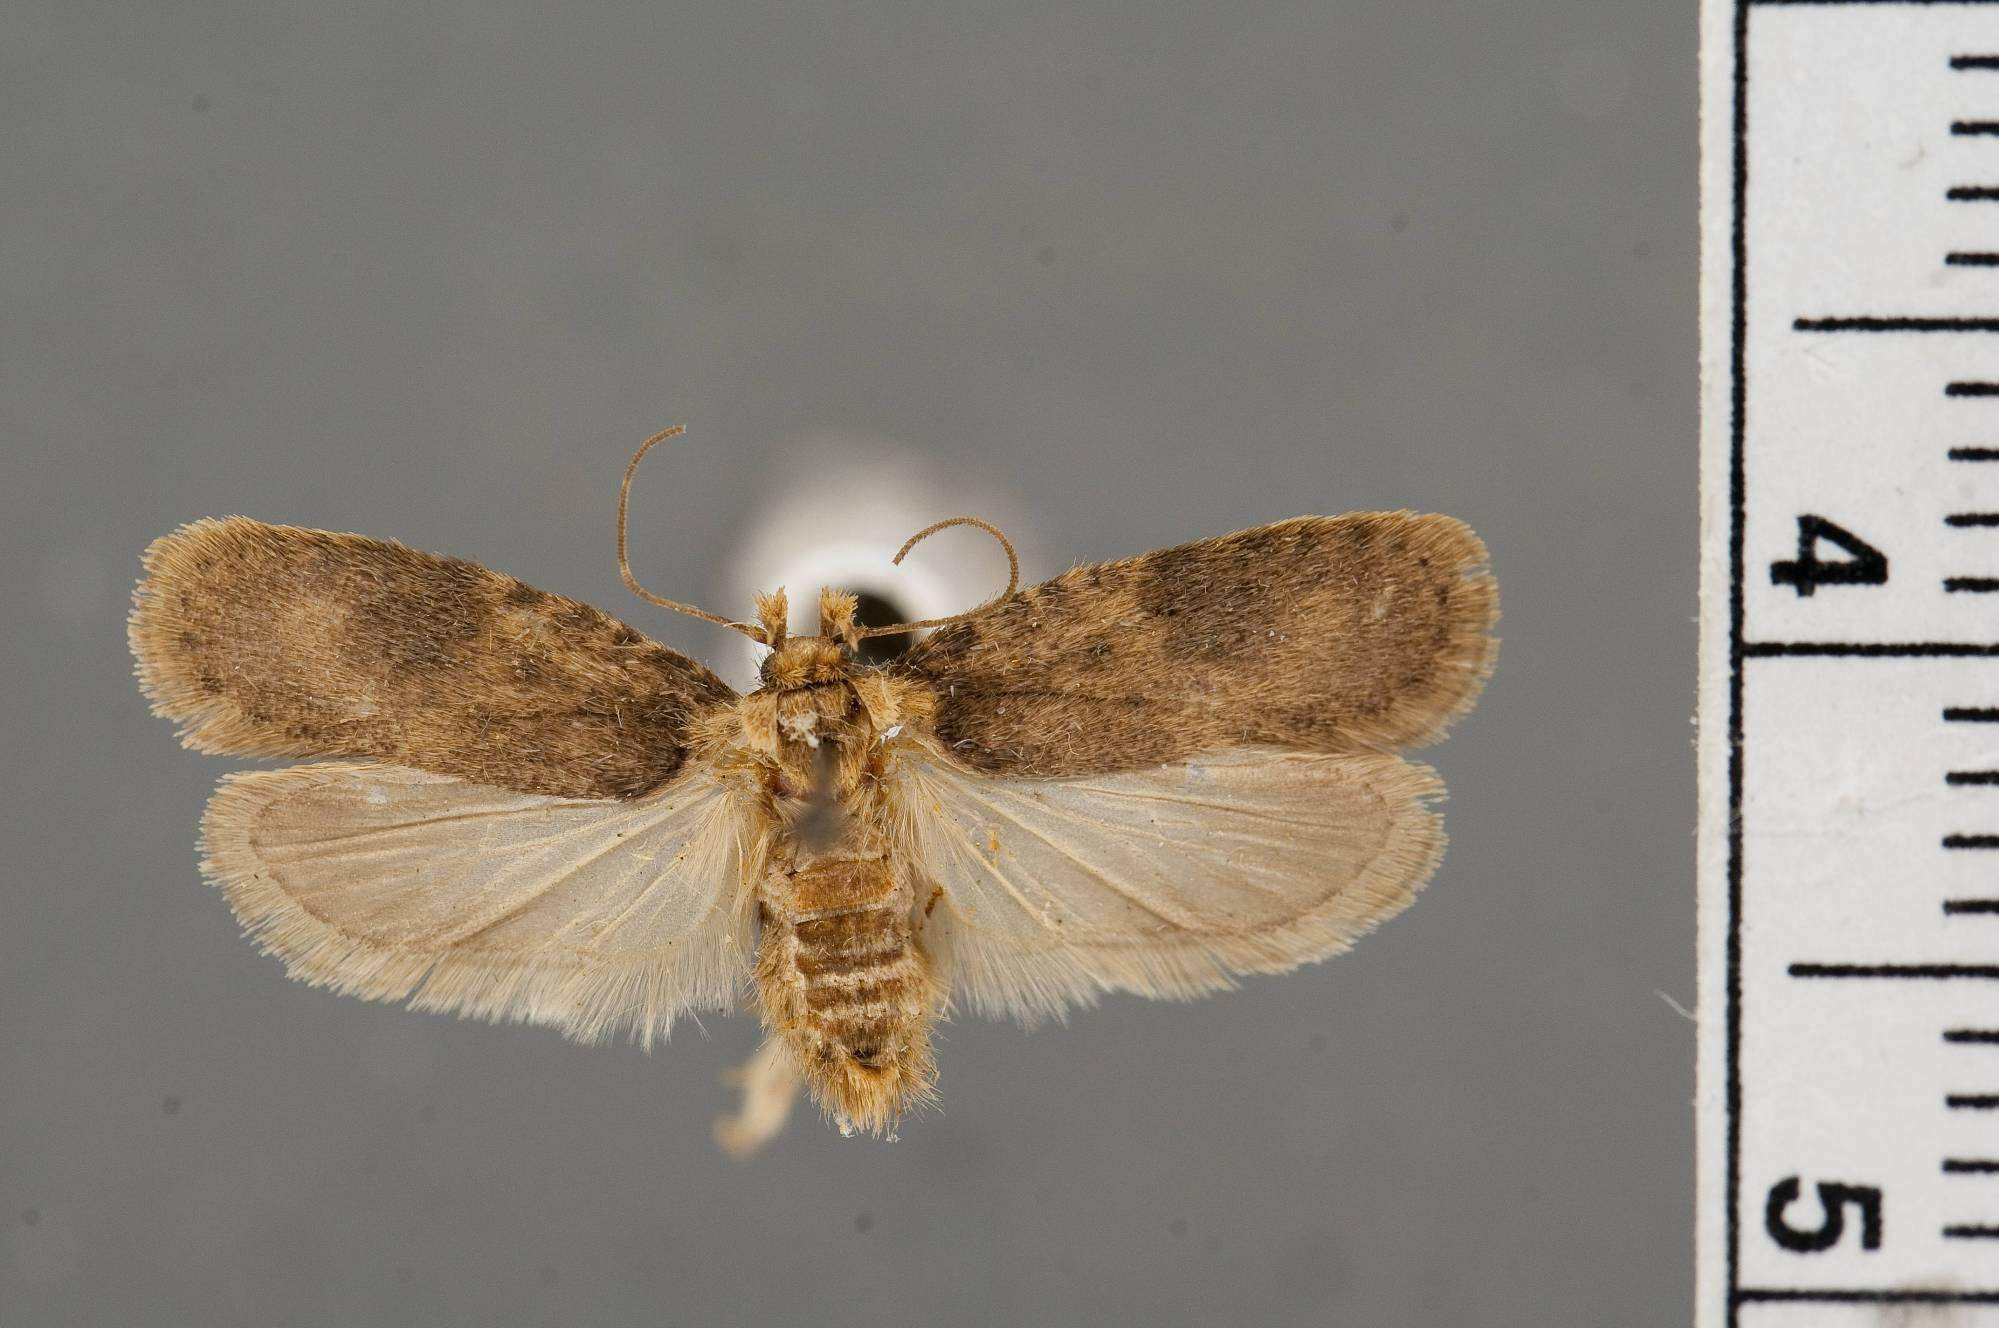

In [ ]:
#| hide

# test how Image.thumbnail works for different heights

testimage = Path("../tests/smithsonian_butterflies_10/jpgs/3fee89f9b-ba5c-4f2e-8532-6e390e2cf0c9.jpg")
im = pil_image.open(testimage)
im

In [ ]:
#| export

def thumb_exact_pad(img, w=128, h=128):
    '''
    resize image so it fits on pre-defined black canvas
    '''
    canvas = img.crop((-1*w,-1*h,0,0))
    thumb = img.copy()
    thumb.thumbnail((w,h)) # this works in place
    canvas.paste(thumb, box=((w-thumb.width)//2, (h-thumb.height)//2))
    return canvas

In [ ]:
#| export

def thumb_exact_height(img, h=128):
    '''
    resize to an exact height
    '''
    w = np.round(h*(img.width/img.height))
    w = np.max([w,h]).astype(int)
    return img.resize((w,h),reducing_gap=2.0)

In [ ]:
#| export

def thumbify(img, w=None,  h=128):
    '''
    create thumbnail for two cases:
    1. Less than or equal to desired height x width, maintain proportion
    2. Exact height, scale width to maintain proportion
    '''
    if w is None: return thumb_exact_height(img, h)
    else: return thumb_exact_pad(img, h, w)

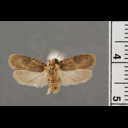

In [ ]:
#| hide

thumbify(im, h=128, w=128)

## Atlases

In [ ]:
#| export

def create_atlases_and_thumbs(imageEngine, plot_id, use_cache:bool=False, autocontrast=True):
    '''create folder with atlases in data dir'''

    print(timestamp(), "Copying images to output directory")

    # create directories
    atlas_dir = Path(imageEngine.out_dir) / "atlases" / str(plot_id)
    atlas_dir.mkdir(exist_ok=True, parents=True)

    thumbs_dir = Path(imageEngine.out_dir) / "thumbs"
    thumbs_dir.mkdir(exist_ok=True)

    orig_dir = Path(imageEngine.out_dir) / "originals"
    orig_dir.mkdir(exist_ok=True)

    # initialize some atlas values
    n_atlases, x, y = 0,0,0
    positions = []
    atlas_size=(imageEngine.atlas_size, imageEngine.atlas_size)

    for img in tqdm(imageEngine, total=imageEngine.count):

        # copy thumbnail
        thumb = thumbify(img.original, h=imageEngine.lod_cell_height)
        if autocontrast: thumb=ImageOps.autocontrast(thumb, preserve_tone=True)
        thumb_w, thumb_h = thumb.width, thumb.height
        thumb.save(thumbs_dir / img.unique_name)

        # copy resized original
        orig = thumbify(img.original, h=600)
        orig.save(orig_dir / img.unique_name)

        # create atlas
        cell = thumbify(img.original, w=None, h=imageEngine.cell_size)
        if autocontrast: cell=ImageOps.autocontrast(cell, preserve_tone=True)

        if (x+cell.width) > atlas_size[0]: # end of a row
            y+=cell.height; x=0
        if (y+cell.height) > atlas_size[0]: # end of first column
            atlas.save(atlas_dir/f"atlas-{n_atlases}.jpg")
            n_atlases+=1
            x,y=0,0 # start a new atlas
        if x == 0 and y == 0:
            atlas=pil_image.new(mode="RGB", size=atlas_size)
        atlas.paste(cell, (x,y))

        ##! I do not not know why I created the logic below, and I am afraid to remove it
        # if cell.width > cell_height:
        #     lod_h = np.round(cell_height*img.height/img.width).astype(np.int32)
        # else: lod_h = cell_height
        # lod_w = np.min([lod_h,cell.width])

        positions.append({
            "idx": n_atlases,
            "x":x, "y":y, "w": thumb_w, "h": thumb_h
        })
        x+=cell.width

    if not (x == 0 and y == 0): # if last atlas wasn't already written
        atlas.save(atlas_dir/f"atlas-{n_atlases}.jpg")
    return atlas_dir.as_posix(), positions

In [ ]:
#| export

def get_image_paths(images:str, out_dir: str) -> List[str]:
    """Called once to provide a list of image paths--handles IIIF manifest input.
    
    args:
        images (str): directory location of images.
        out_dir (str): output directory for downloaded IIIF files.

    returns:
        image_paths list(str): list of image paths.

    Note:
        Old/previous images are not deleted from IIIF directory.

    Todo:
        Consider separate function that handles IIIF images
        from glob images.
    """

    image_paths = None

    # allow images to be input as list, i.e. from tables input
    if isinstance(images, list):
        image_paths = images
    # Is images a iiif file or image directory?
    elif os.path.isfile(images):
        # Handle list of IIIF image inputs
        iiif_dir = os.path.join(out_dir,"iiif-downloads")

        # Check if directory already contains anything
        if os.path.exists(iiif_dir) and os.listdir(iiif_dir):
            print("Warning: IIIF directory already contains content!")

        with open(images) as f:
            urls = [url.strip() for url in f.read().split("\n") if url.startswith("http")]
            count = 0
            for url in urls:
                try:
                    Manifest(url=url, out_dir=iiif_dir).save_images(limit=1)
                    count += 1
                except:
                    print(timestamp(), "Could not download url " + url)

            if count == 0:
                raise Exception('No IIIF images were successfully downloaded!')

            image_paths = glob(os.path.join(out_dir,"iiif-downloads", "images", "*"), recursive=True)
   
    # handle case where images flag points to a glob of images
    if not image_paths:
        image_paths = glob(images, recursive=True)

    # handle case user provided no images
    if not image_paths:
        raise FileNotFoundError("Error: No input images were found. Please check your --images glob")

    return image_paths

## Image class

In [ ]:
#| export

class Image:
    def __init__(self, img_path: str, metadata: Optional[dict] = None) -> 'Image':
        self.path = img_path
        self._original = None
        self._filename = None
        self._unique_name = None
        self.metadata = metadata if metadata else {}

    @property
    def original(self):
        if self._original is None:
            self._original = load_image(self.path)
        return self._original
    
    @property
    def filename(self):
        if self._filename is None:
            self._filename = clean_filename(self.path)
        return self._filename
    
    @property
    def unique_name(self):
        """Save as name when copying image."""
        if self._unique_name is None:
            self._unique_name = self.filename
        return self._unique_name


    def valid(self, lod_cell_height: int, oblong_ratio: Union[int,float]) -> tuple[bool, str]:
        """Validate that image can be opened and loaded correctly.

        Args:
            lod_cell_height (int):
            oblong_ratio (int|float): atlas_size/cell_size ratio

        Returns:
            Tuple[pass,msg]:
                pass (bool): True if passed validation
                msg (str): Reason why validation failed 
        """
        w, h = self.original.size
        # remove images with 0 height or width when resized to lod height
        if (h == 0) or (w == 0):
            return False, f"Skipping {self.path} because it contains 0 height or width"
        # remove images that have 0 height or width when resized
        try:
            resized = thumbify(self.original, lod_cell_height)
        except ValueError:
            return False, f"Skipping {self.path} because it contains 0 height or width when resized"
        except OSError:
            return False, f"Skipping {self.path} because it could not be resized"
        # remove images that are too wide for the atlas
        if (w / h) > (oblong_ratio):
            return False, f"Skipping {self.path} because its dimensions are oblong"

        return True, ""

## Image Factory

Our goal is to provide an extensible backbone for clip-plot by implementing an agnostic image engine.
Images and their metadata might need to be processed from different sources.  
In addition the fallowing issues must be handled by the image engine:
  - Matching metadata with their images
  - Handling non-unique image names




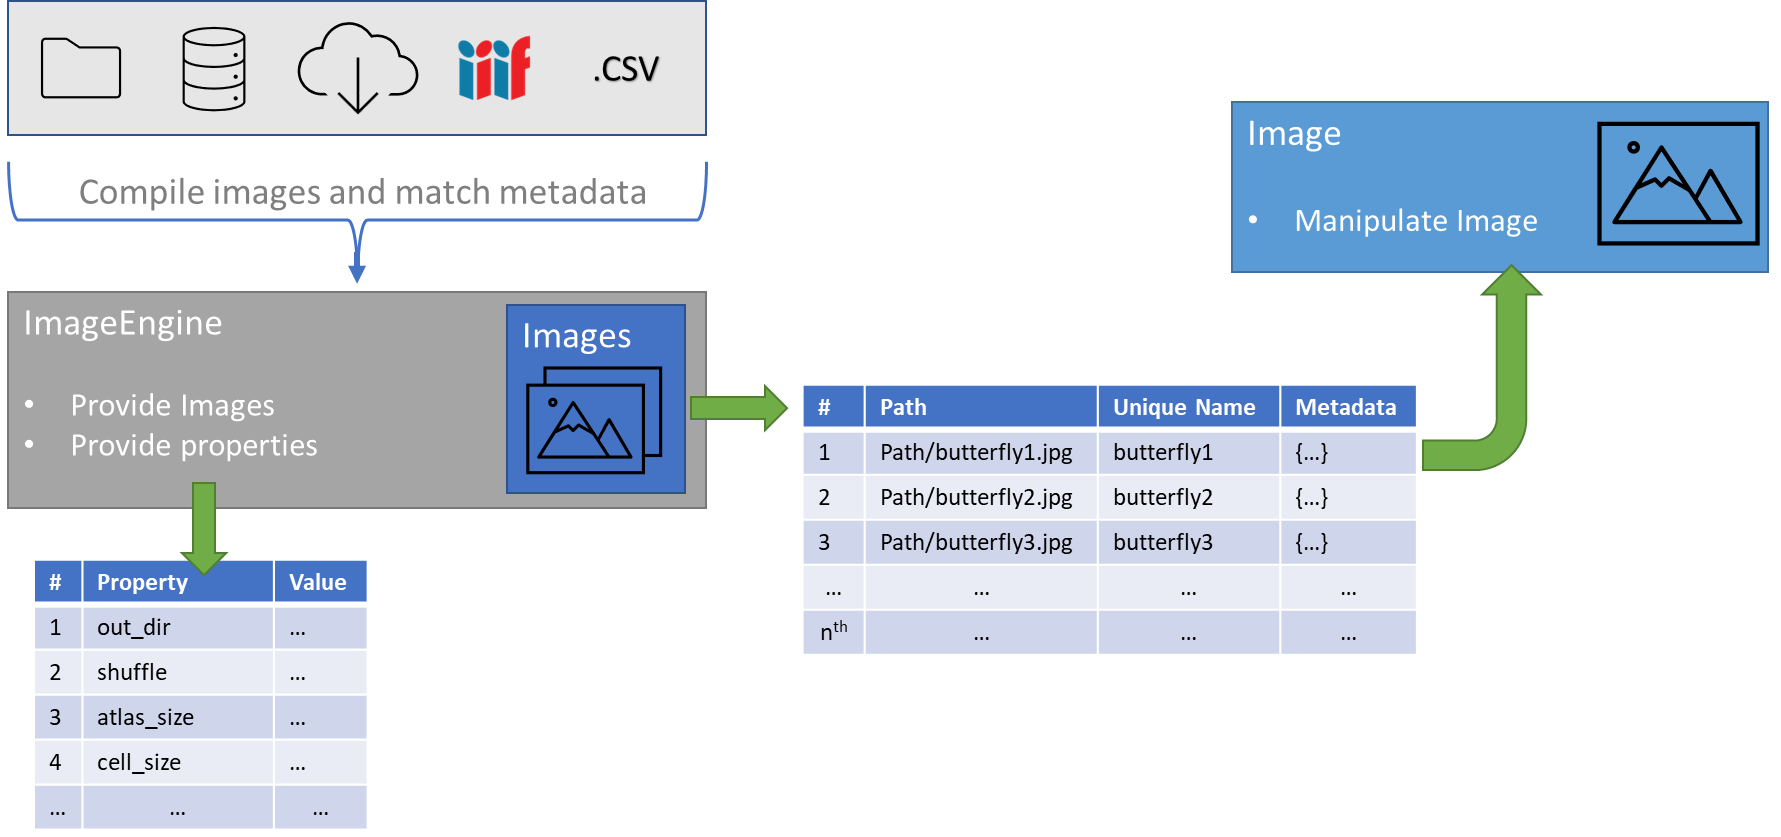

In [ ]:
#| export
class ImageFactoryBase(ABC):
    """Class encapsulates functionality required to access images,
    including compiling metadata.

    Factory is responsible :
        - Compiling image files and their metadata
        - Filtering and validating images
        - Naming image output names
        - Providing property values

    Image factory needs to be able to provide an Image instance
        - The image instance needs to be have it's metadata (if applicable)

    Notes:
        Class and their children are required to provide the following properties:
            out_dir
            shuffle
            atlas_size
            cell_size
            lod_cell_height
    """        

    # Required property values
    DEFAULT_OPTIONS = {
        'shuffle': False, # (Optional[bool], default = False): Shuffle image order
        'atlas_size': 2048, # (int, default = 2048)
        'cell_size': 32, # (int, default = 32)
        'lod_cell_height': 128, # (int, default = 128)
    }

    def __init__(self, out_dir: str) -> None:
        """Initialize ImageEngine instance

        Args:
            out_dir (str): output directory of data

        """
        # Required initialized properties
        self.out_dir = out_dir
        self.count = 0  # Total number of images
        self.meta_headers = [] # Headers in metadata
        self.metadata = [] # List of metadata

        # Required property values
        self.shuffle = self.DEFAULT_OPTIONS['shuffle']
        self.atlas_size = self.DEFAULT_OPTIONS['atlas_size']
        self.cell_size = self.DEFAULT_OPTIONS['cell_size']
        self.lod_cell_height = self.DEFAULT_OPTIONS['lod_cell_height']

    @abstractmethod
    def __iter__(self):
        # Yield an Image instance
        pass
    
    @abstractmethod
    def __getitem__(self, index):
        # Return index's Image instance
        pass
    

class ImageFactory(ImageFactoryBase):
    # Default internal values
    DEFAULT_OPTIONS = ImageFactoryBase.DEFAULT_OPTIONS.copy()
    DEFAULT_OPTIONS.update({
        'seed': "", # (int): Seed for random generator
        'max_images': False, # (Union[False,int]): Maximum number of images
        'validate': True, # Validate Images
    })
    
    def __init__(self, img_path, out_dir, meta_dir, options={}) -> None:
        super().__init__(out_dir)
        self.img_path = img_path
        self.meta_dir = meta_dir
        self.filenames = []
        self.image_paths = []
        
        # Load options
        for option, default in self.DEFAULT_OPTIONS.items():
            setattr(self, option, options.get(option, default))

        self.filter_images()

    def __iter__(self):
        for img in self.stream_images(self.image_paths, self.metadata):
            yield img

    def __getitem__(self, index):
        if index < len(self.image_paths):
            if self.metadata:
                meta = self.metadata[index]
            else:
                meta = None
    
            return Image(self.image_paths[index], meta)

    def filter_images(self):
        """Main method for filtering images given user metadata (if provided)

        -Validate image:
            Loading (done by stream_images and Images)
            Size
            resizing
            oblong

        -Compare against metadata
        
        Args:
            images (str): Directory location of images.
            out_dir (str): Output directory.
            shuffle (Optional[bool], default = False): Shuffle image order
            seed (int): Seed for random generator
            max_images (Union[bool,int]): Maximum number of images
            atlas_size (int, default = 2048)
            cell_size (int, default = 32)
            lod_cell_height (int, default = 128)
            meta_dir (str): Directory of image metadata

        Returns:
            images (list[str])
            metadata (list[dict])

        Notes:
            Assumes 'filename' is provided in metadata
            Convoluted compiling of metadata
            Should All Validation should belong to Image class?
            Need to split function
        """
        # validate that input image names are unique
        image_paths = get_image_paths(images=self.img_path, out_dir=self.out_dir)
        image_names = list(map(clean_filename,image_paths))
        duplicates = set([x for x in image_names if image_names.count(x) > 1])

        if duplicates:
            raise Exception(
                """Image filenames should be unique, but the following 
                filenames are duplicated\n{}""".format("\n".join(duplicates)))
        
        # optionally shuffle the image_paths
        if self.shuffle:
            print(timestamp(), "Shuffling input images")
            random.Random(self.seed).shuffle(image_paths)
        else:
            image_paths = sorted(image_paths)

        # Optionally limit the number of images in image_paths
        if self.max_images:
            image_paths = image_paths[: self.max_images]        

        # process and filter the images
        filtered_image_paths = {}
        oblong_ratio = self.atlas_size/ self.cell_size

        print(timestamp(), "Validating input images")
        for img in tqdm(self.stream_images(image_paths, []), total=len(image_paths)):
            if self.validate is True:
                valid, msg = img.valid(lod_cell_height=self.lod_cell_height, oblong_ratio=oblong_ratio) 
                if valid is True:
                    filtered_image_paths[img.path] = img.filename
                else:
                    print(timestamp(), msg)
            else:
                filtered_image_paths[img.path] = img.filename
                

        # if there are no remaining images, throw an error
        if len(filtered_image_paths) == 0:
            raise Exception("No images were found! Please check your input image glob.")

        # handle the case user provided no metadata
        if not self.meta_dir:
            print(timestamp(), "No metadata directory was provided.")
            self.image_paths = list(filtered_image_paths.keys())
            self.count = len(self.image_paths)
            self.filenames = list(filtered_image_paths.values())
            return

        # handle user metadata: retain only records with image and metadata
        metaList, self.meta_headers = get_metadata_list(meta_dir=self.meta_dir)
        metaDict = {clean_filename(i.get(FILE_NAME, "")): i for i in metaList}
        meta_bn = set(metaDict.keys())
        img_bn = set(filtered_image_paths.values())

        # identify images with metadata and those without metadata
        meta_present = img_bn.intersection(meta_bn)
        meta_missing = list(img_bn - meta_bn)

        # notify the user of images that are missing metadata
        if meta_missing:
            print(
                timestamp(),
                " ! Some images are missing metadata:\n  -",
                "\n  - ".join(meta_missing[:10]),
            )
            if len(meta_missing) > 10:
                print(timestamp(), " ...", len(meta_missing) - 10, "more")

            if os.path.exists(self.out_dir) is False:
                os.makedirs(self.out_dir)
                
            missing_dir = os.path.join(self.out_dir,"missing-metadata.txt")
            with open(missing_dir, "w") as out:
                out.write("\n".join(meta_missing))

        if not meta_present:
            raise Exception( f"""No image has matching metadata. Check if '{FILE_NAME}' key was provided in metadata files""")

        # get the sorted lists of images and metadata
        images = []
        metadata = []
        for path, fileName in filtered_image_paths.items():
            if fileName in meta_present:
                images.append(path)
                metadata.append(copy.deepcopy(metaDict[fileName]))
                self.filenames.append(fileName)

        self.image_paths = images
        self.metadata = metadata
        self.count = len(self.image_paths)


    @staticmethod
    def stream_images(image_paths: List[str], metadata: Optional[List[dict]] = None) -> 'Image':
        """Read in all images from args[0], a list of image paths
        
        Args:
            image_paths (list[str]): list of image locations
            metadata (Optional[list[dist]]): metadata for each image
        
        Returns:
            yields Image instance

        Notes:
            image is matched to metadata by index location
                Matching by key would be better
        """
        for idx, imgPath in enumerate(image_paths):
            try:
                meta = None
                if metadata and metadata[idx]:
                    meta = metadata[idx]
                yield Image(imgPath, meta)
            except Exception as exc:
                print(timestamp(), "Image", imgPath, "could not be processed --", exc)

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()